In [1]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/21087
# 标题：RSRS系列一：完整复现版(自带快速回测框架)

from jqdata import jy
from jqdata import *
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from scipy import stats
import warnings 
warnings.filterwarnings('ignore')

In [2]:
data_panel = get_price('000300.XSHG',start_date = '2003-01-01', end_date = '2019-07-04',fields = ['close','open','high','low','volume'])
data_panel = data_panel.dropna()

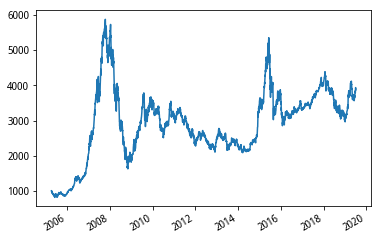

In [3]:
data_panel['close'].plot()

In [4]:
#回撤函数
def max_drawdown(pnl):
    pnl = pnl[~np.isnan(pnl)]
    high = pnl[0]
    low = high
    max_draw = 0
    for i in range(len(pnl)-1):
        if pnl[i+1]>high:
            high = pnl[i+1]
            low = high
        elif pnl[i+1]<low:
            low = pnl[i+1]
            if max_draw< 1-low/high:
                max_draw = 1 - low/high
    return max_draw

#夏普函数
def sharp_ratio(pnl,r=0.03):
    pnl = pnl[~np.isnan(pnl)]
    #print(pnl)
    return_rate_year = (pnl[-1]/pnl[0])**(250/len(pnl))-1
    std_year = np.std(np.diff(pnl)/pnl[:-1]-1)*np.sqrt(250)
    return (return_rate_year-r)/std_year


# *均线策略

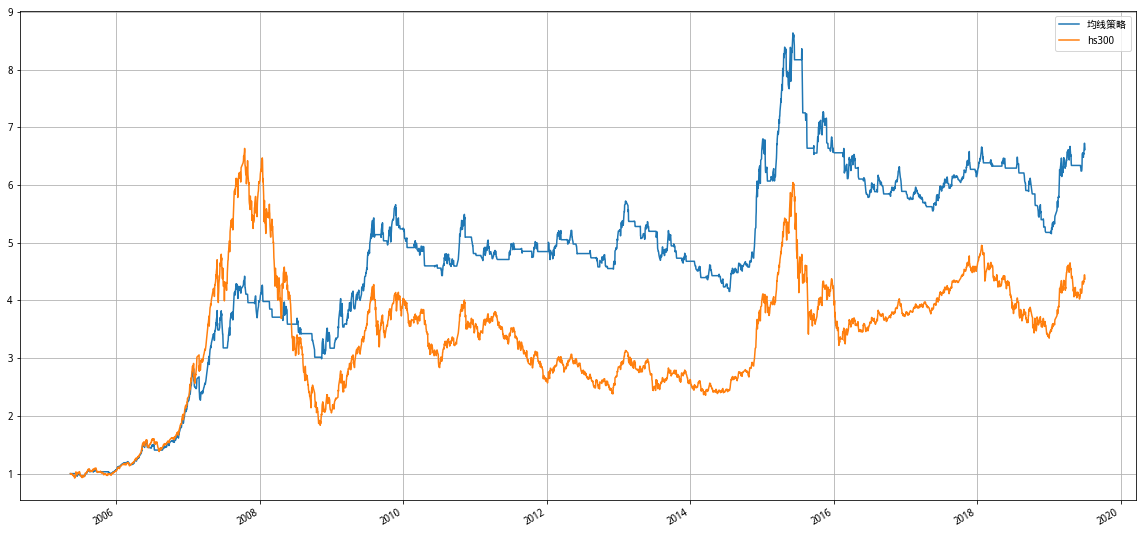

In [5]:
#均线策略
data_test = data_panel.copy()
data_test['Ma_10'] = data_test['close'].rolling(10).mean()
data_test['Ma_20'] = data_test['close'].rolling(20).mean()
data_test = data_test.dropna()

OPEN = data_test.open.values
CLOSE = data_test.close.values
Indexs = data_test.index
Ma_10 = data_test.Ma_10.values
Ma_20 = data_test.Ma_20.values

buyfee = 0.0013
sellfee = 0.0013

pnl = pd.Series(index = Indexs)
position = 0

for idx,time_stamp in enumerate(Indexs):
    if idx<=1:
        pnl.iloc[idx]=1
        continue
    
    
    if Ma_20[idx-1]<=CLOSE[idx-1]:
        if position==0:
            position = pnl.iloc[idx-1]/OPEN[idx]/(1+buyfee)
            pnl.iloc[idx] = position * CLOSE[idx]
        else:
            pnl.iloc[idx] = position * CLOSE[idx]
    else:
        if position>0:
            pnl.iloc[idx] = position* OPEN[idx]*(1-sellfee)
            position = 0
        else:
            pnl.iloc[idx]=pnl.iloc[idx-1]

plt.figure(figsize = (20,10))
pnl.plot(label = '均线策略')
(data_test['close'].loc[pnl.index]/(data_test['close'].loc[pnl.index][0])).plot(label = 'hs300')
plt.legend()
plt.grid()

# *布林带策略

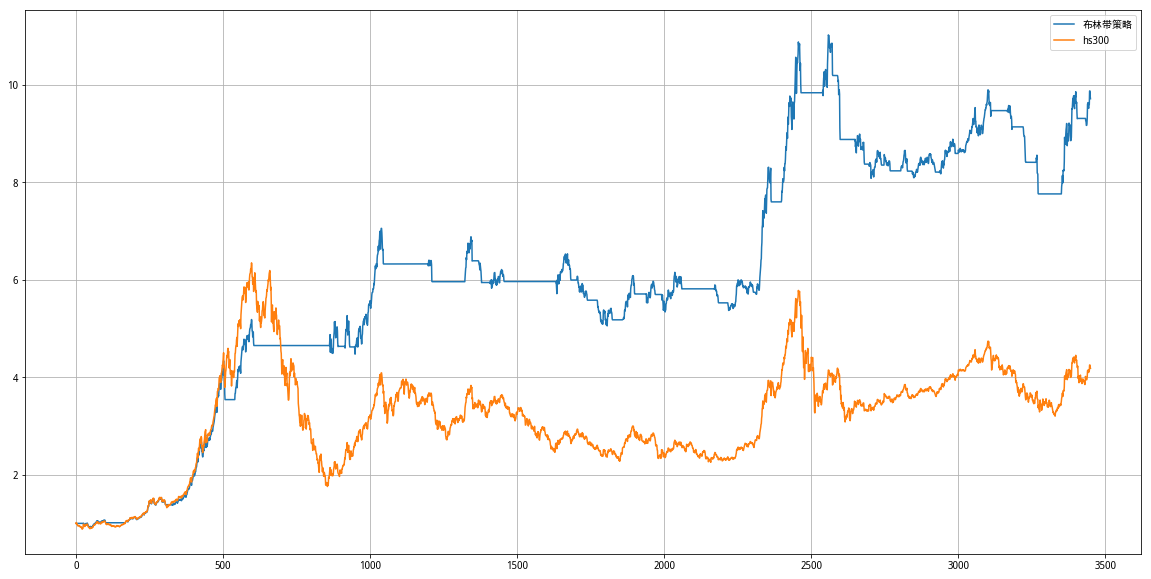

In [6]:
#布林带策略
data_test = data_panel.copy()
data_test['Std_14'] = data_test['close'].rolling(14).std()
data_test['Ma_14'] = data_test['close'].rolling(14).mean()

data_test = data_test.dropna()

OPEN = data_test.open.values
CLOSE = data_test.close.values
Indexs = data_test.index
Ma_14 = data_test.Ma_14.values
Std_14 = data_test.Std_14.values

#费率+滑点
buyfee = 0.0013
sellfee = 0.0013

pnl = np.full(len(Indexs), np.nan)
position = 0

for idx,time_stamp in enumerate(Indexs):
    if idx<=1:
        pnl[idx]=1
        continue
    
    #买入条件
    if CLOSE[idx-1]-Ma_14[idx-1]>=Std_14[idx-1]*2:
        if position==0:
            position = pnl[idx-1]/OPEN[idx]/(1+buyfee)
            pnl[idx] = position * CLOSE[idx]
        else:
            pnl[idx] = position * CLOSE[idx]
    #卖出条件
    elif CLOSE[idx-1]-Ma_14[idx-1]<=-Std_14[idx-1]*2:
        if position>0:
            pnl[idx] = position* OPEN[idx]*(1-sellfee)
            position = 0
        else:
            pnl[idx]=pnl[idx-1]
    else:
        if position>0:
            pnl[idx] = position* CLOSE[idx]
        else:
            pnl[idx]=pnl[idx-1]

pnl = pnl[~np.isnan(pnl)]
    
plt.figure(figsize = (20,10))
plot(pnl,label = '布林带策略')
plot(CLOSE[-len(pnl):]/CLOSE[-(len(pnl))],label='hs300')
plt.legend()
plt.grid()

# *无标准分与标准分分布和走势

In [7]:
#无标准化斜率
N = 18
data_test =data_panel.copy()
data_test = data_test.dropna()

Indexs = data_test.index
High = data_test.high.values
Low = data_test.low.values

slope = np.full(len(Indexs), np.nan)

for i in range(len(data_test)):
    if i<N:
        continue
    slope[i] = np.polyfit(x = Low[(i+1-N):(i+1)],y=High[(i+1-N):(i+1)],deg=1)[0]

slope = slope[~np.isnan(slope)]

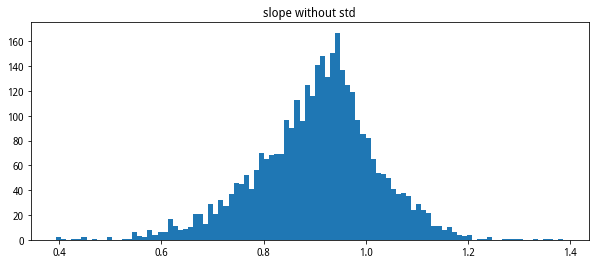

In [8]:
#画直方图观察分布
plt.figure(figsize =(10,4))
plt.hist(slope, bins=100)  # arguments are passed to np.histogram
plt.title("slope without std")
plt.show()

In [9]:
#计算相关统计量
print("mean:%.4f" % np.mean(slope))
print("std:%.4f" % np.std(slope))
print("skew:%.4f" % stats.skew(slope)) 
print("kurtosis:%.4f" % stats.kurtosis(slope))

mean:0.9038
std:0.1175
skew:-0.3511
kurtosis:0.9285


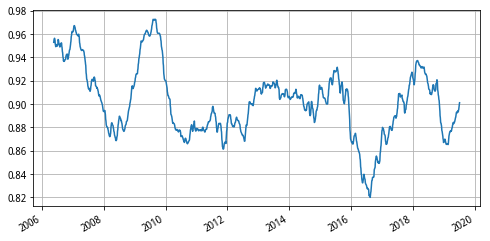

In [10]:
#观察各时期的均值变化
plt.figure(figsize = (8,4))
slope = pd.Series(slope,index = Indexs[-len(slope):])
slope.rolling(250).mean().plot()
plt.grid()

In [11]:
#标准化斜率
M = 600
slope_std = np.full(len(slope), np.nan)

for i in range(len(slope)):
    if i<M:
        continue
    slope_std[i] = (slope[i] - np.mean(slope[(i+1-M):(i+1)]))/np.std(slope[(i+1-M):(i+1)])
slope_std = slope_std[~np.isnan(slope_std)]

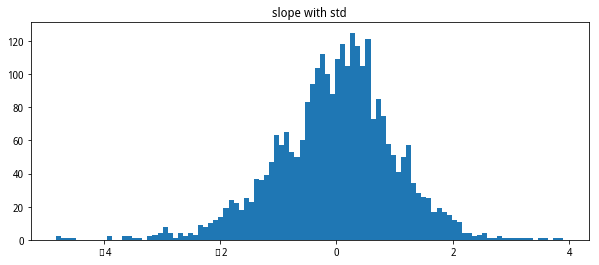

In [12]:
#画直方图观察分布
plt.figure(figsize = (10,4))
plt.hist(slope_std, bins=100)  # arguments are passed to np.histogram
plt.title("slope with std")
plt.show()

In [13]:
#计算相关统计量
print("mean:%.4f" % np.mean(slope_std))
print("std:%.4f" % np.std(slope_std))
print("skew:%.4f" % stats.skew(slope_std)) 
print("kurtosis:%.4f" % stats.kurtosis(slope_std))

mean:-0.0137
std:1.0176
skew:-0.3866
kurtosis:1.2660


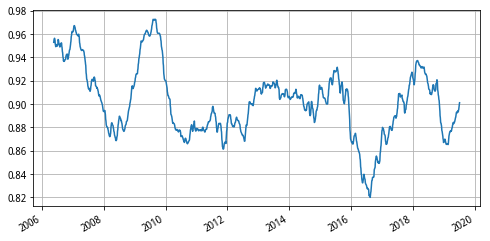

In [14]:
#观察各时期的均值变化
plt.figure(figsize = (8,4))
slope_std = pd.Series(slope_std,index = Indexs[-len(slope_std):])
slope.rolling(250).mean().plot()
plt.grid()

# *无标准分策略与标准分策略比较

In [15]:
#无标准化斜率策略

#数据初始化
data_test = data_panel.copy()
data_test = data_test.dropna()
data_test['slope'] = slope
data_test['slope_std'] = slope_std

data_test = data_test.dropna()

OPEN = data_test.open.values
CLOSE = data_test.close.values
Indexs = data_test.index
Slope = data_test.slope
Slope_std = data_test.slope_std

#策略初始化
buyfee = 0.0013
sellfee = 0.0013

pnl = np.full(len(Indexs), np.nan)
position = 0

for idx,time_stamp in enumerate(Indexs):
    if idx<=1:
        pnl[idx]=1
        continue
    
    ##定义买入条件
    if Slope[idx-1]>1:
        if position==0:
            position = pnl[idx-1]/OPEN[idx]/(1+buyfee)
            pnl[idx] = position * CLOSE[idx]
        else:
            pnl[idx] = position * CLOSE[idx]
    ##定义卖出条件
    elif Slope[idx-1]<0.8:
        if position>0:
            pnl[idx] = position* OPEN[idx]*(1-sellfee)
            position = 0
        else:
            pnl[idx]=pnl[idx-1]
    else:
        if position>0:
            pnl[idx] = position* CLOSE[idx]
        else:
            pnl[idx]=pnl[idx-1]

pnl = pd.Series(pnl,index =Indexs)
pnl = pnl.dropna()
pnl_slope = pnl.copy()

In [16]:
#标准化斜率策略

#数据初始化
data_test = data_panel.copy()
data_test = data_test.dropna()
data_test['slope'] = slope
data_test['slope_std'] = slope_std

data_test = data_test.dropna()

OPEN = data_test.open.values
CLOSE = data_test.close.values
Indexs = data_test.index
Slope = data_test.slope
Slope_std = data_test.slope_std

#策略初始化
buyfee = 0.0013
sellfee = 0.0013

pnl = np.full(len(Indexs), np.nan)
position = 0

for idx,time_stamp in enumerate(Indexs):
    if idx<=1:
        pnl[idx]=1
        continue
    
    ##定义买入条件
    if Slope_std[idx-1]>1:
        if position==0:
            position = pnl[idx-1]/OPEN[idx]/(1+buyfee)
            pnl[idx] = position * CLOSE[idx]
        else:
            pnl[idx] = position * CLOSE[idx]
    ##定义卖出条件
    elif Slope_std[idx-1]<-0.7:
        if position>0:
            pnl[idx] = position* OPEN[idx]*(1-sellfee)
            position = 0
        else:
            pnl[idx]=pnl[idx-1]
    else:
        if position>0:
            pnl[idx] = position* CLOSE[idx]
        else:
            pnl[idx]=pnl[idx-1]

pnl = pd.Series(pnl,index =Indexs)
pnl = pnl.dropna()

pnl_slope_std = pnl.copy()

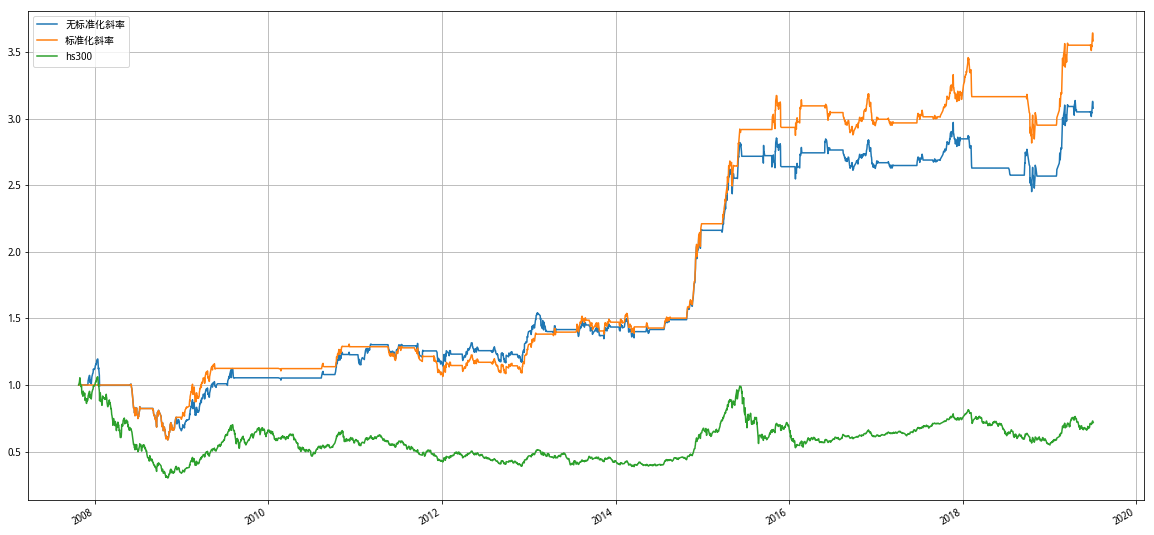

In [17]:
plt.figure(figsize = (20,10))
pnl_slope.plot(label = '无标准化斜率')
pnl_slope_std.plot(label = '标准化斜率')
close_plot = data_test['close'].loc[pnl.index]
(close_plot/close_plot[0]).plot(label='hs300')
plt.legend()
plt.grid()

# *测试N参数敏感性

In [18]:
## 测试斜率策略参数敏感性
#无标准化斜率策略
def trade_slope(N):
    
    #无标准化斜率
    data_test =data_panel.copy()
    data_test = data_test.dropna()

    Indexs = data_test.index
    High = data_test.high.values
    Low = data_test.low.values

    slope = np.full(len(Indexs), np.nan)

    for i in range(len(data_test)):
        if i<N:
            continue
        slope[i] = np.polyfit(x = Low[(i-N):i],y=High[(i-N):i],deg=1)[0]

    #slope = slope[~np.isnan(slope)]
    data_test['slope'] = slope
    
    data_test = data_test.dropna()
    OPEN = data_test.open.values
    CLOSE = data_test.close.values
    Indexs = data_test.index
    Slope = data_test.slope
    
    #策略初始化
    buyfee = 0.0013
    sellfee = 0.0013

    pnl = np.full(len(Indexs), np.nan)
    position = 0

    for idx,time_stamp in enumerate(Indexs):
        if idx<=1:
            pnl[idx]=1
            continue

        ##定义买入条件
        if Slope[idx-1]>1:
            if position==0:
                position = pnl[idx-1]/OPEN[idx]/(1+buyfee)
                pnl[idx] = position * CLOSE[idx]
            else:
                pnl[idx] = position * CLOSE[idx]
        ##定义卖出条件
        elif Slope[idx-1]<0.8:
            if position>0:
                pnl[idx] = position* OPEN[idx]*(1-sellfee)
                position = 0
            else:
                pnl[idx]=pnl[idx-1]
        else:
            if position>0:
                pnl[idx] = position* CLOSE[idx]
            else:
                pnl[idx]=pnl[idx-1]

    pnl = pd.Series(pnl,index =Indexs)
    pnl = pnl.dropna()
    pnl_slope = pnl.copy()
    
    return pnl

Text(0, 0.5, 'Sharp_ratio')

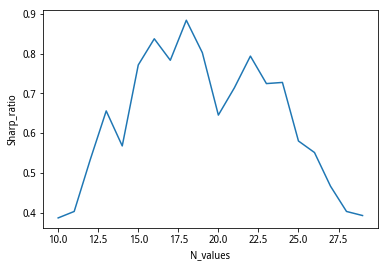

In [19]:
## 各参数夏普值
sharp_store = []
for N in arange(10,30):
    sharp_store.append(sharp_ratio(trade_slope(N)[30-len(data_panel):]))
plt.plot(np.arange(10,30),sharp_store)
plt.xlabel("N_values")
plt.ylabel("Sharp_ratio")

### 可以看出参数在18附近夏普达到最大，且参数分布呈现凸峰，参数较为有效

# *计算比较标准分，修正标准分，右偏修正标准分

In [20]:
## 计算标准化斜率,修正的标准化斜率,和右偏修正标准化斜率

N = 18
data_test =data_panel.copy()
data_test = data_test.dropna()

Indexs = data_test.index
High = data_test.high.values
Low = data_test.low.values
CLOSE = data_test.close.values


slope = np.full(len(Indexs), np.nan)
r_2 = np.full(len(Indexs), np.nan)

slope_std = np.full(len(slope), np.nan)
slope_std_adp = np.full(len(slope), np.nan)
slope_std_adp_right = np.full(len(slope), np.nan)
return_store = np.full(len(slope), np.nan)

M = 600

for i in range(len(Indexs)):
    if i<N-1:
        continue
    slope_t,_,r_value_t,_,_ = stats.linregress(x=Low[(i+1-N):(i+1)],y=High[(i+1-N):(i+1)])    
    slope[i] = slope_t
    r_2[i] = r_value_t**2
    #标准化斜率
    slope_std[i] = (slope[i] - np.mean(slope[(i+1-M):(i+1)]))/np.std(slope[(i+1-M):(i+1)])
    
    if i<(len(Indexs)-10): 
        return_store [i] = CLOSE[i+10] / CLOSE[i]-1
        if i>=M: 
            #修正标准化斜率
            slope_std_adp[i] = r_2[i] * slope_std[i]
            #右偏修正标准化斜率
            slope_std_adp_right[i] = slope_std_adp[i]*slope[i] 

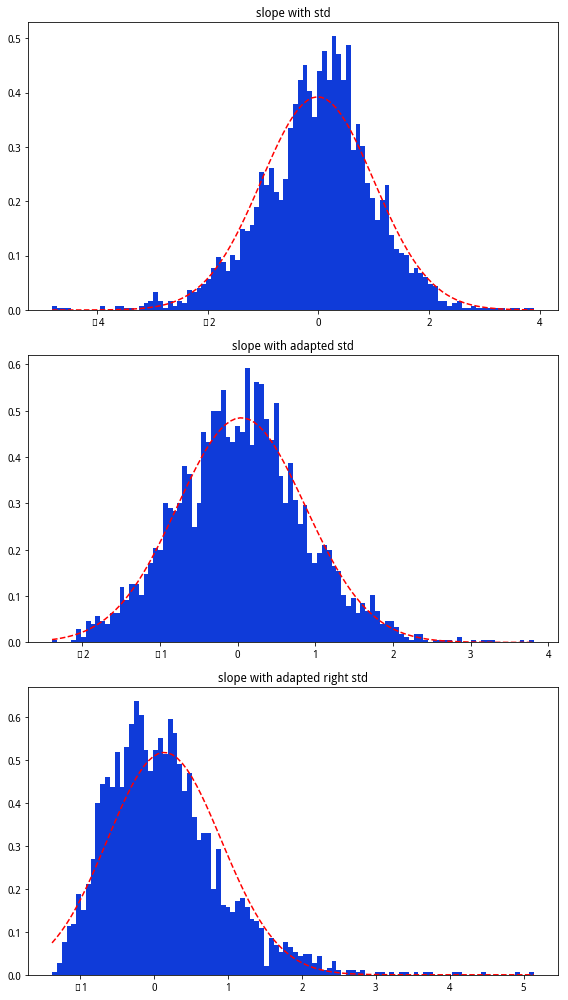

In [21]:
#画直方图观察分布
num_bins=100

plt.figure(figsize = (8,14))

slope_std_new = slope_std[~np.isnan(slope_std)].copy()
slope_std_adp_new = slope_std_adp[~np.isnan(slope_std_adp)].copy()
slope_std_adp_right_new = slope_std_adp_right[~np.isnan(slope_std_adp_right)].copy()

#标准化斜率
plt.subplot(311)
plt.hist(slope_std_new,bins = num_bins, normed = True)
plt.title("slope with std")
n, bins, patches = plt.hist(slope_std_new, num_bins,normed=1, facecolor='blue', alpha=0.5) 
mu =np.mean(slope_std_new) #计算均值 
sigma =np.std(slope_std_new)
y = mlab.normpdf(bins, mu, sigma)#拟合一条最佳正态分布曲线y 
plt.plot(bins, y, 'r--')

#修正标准化斜率
plt.subplot(312)
plt.hist(slope_std_adp_new,bins = num_bins, normed = True)
plt.title("slope with adapted std")
n, bins, patches = plt.hist(slope_std_adp_new, num_bins,normed=1, facecolor='blue', alpha=0.5) 
mu =np.mean(slope_std_adp_new) #计算均值 
sigma =np.std(slope_std_adp_new)
y = mlab.normpdf(bins, mu, sigma)#拟合一条最佳正态分布曲线y 
plt.plot(bins, y, 'r--')

#右偏修正标准化斜率
plt.subplot(313)
plt.hist(slope_std_adp_right_new,bins = num_bins, normed = True)
plt.title("slope with adapted right std")
n, bins, patches = plt.hist(slope_std_adp_right_new, num_bins,normed=1, facecolor='blue', alpha=0.5) 
mu =np.mean(slope_std_adp_right_new) #计算均值 
sigma =np.std(slope_std_adp_right_new)
y = mlab.normpdf(bins, mu, sigma)#拟合一条最佳正态分布曲线y 
plt.plot(bins, y, 'r--')

plt.tight_layout()
plt.show()

In [22]:
#计算相关统计量
print("std slope mean:%.4f\nadapted std slope mean:%.4f\nadapted right std slope mean:%.4f" % (np.mean(slope_std_new),np.mean(slope_std_adp_new),np.mean(slope_std_adp_right_new)))
print("-"*32)
print("std slope std:%.4f\nadapted slope std std:%.4f\nadapted right std slope mean:%.4f" % (np.std(slope_std_new),np.std(slope_std_adp_new),np.std(slope_std_adp_right_new)))
print("-"*32)
print("std slope skew:%.4f\nadapted slope std skew:%.4f\nadapted right std slope mean:%.4f" % (stats.skew(slope_std_new),stats.skew(slope_std_adp_new),stats.skew(slope_std_adp_right_new))) 
print("-"*32)
print("std slope kurtosis:%.4f\nadapted slope std kurtosis:%.4f\nadapted right std slope mean:%.4f" % (stats.kurtosis(slope_std_new),stats.kurtosis(slope_std_adp_new),stats.kurtosis(slope_std_adp_right_new)))

std slope mean:-0.0141
adapted std slope mean:0.0493
adapted right std slope mean:0.1371
--------------------------------
std slope std:1.0173
adapted slope std std:0.8230
adapted right std slope mean:0.7707
--------------------------------
std slope skew:-0.3856
adapted slope std skew:0.2316
adapted right std slope mean:1.0951
--------------------------------
std slope kurtosis:1.2664
adapted slope std kurtosis:0.3804
adapted right std slope mean:2.5892


Text(0.5, 1.0, 'right adapted std slope vs return-mean')

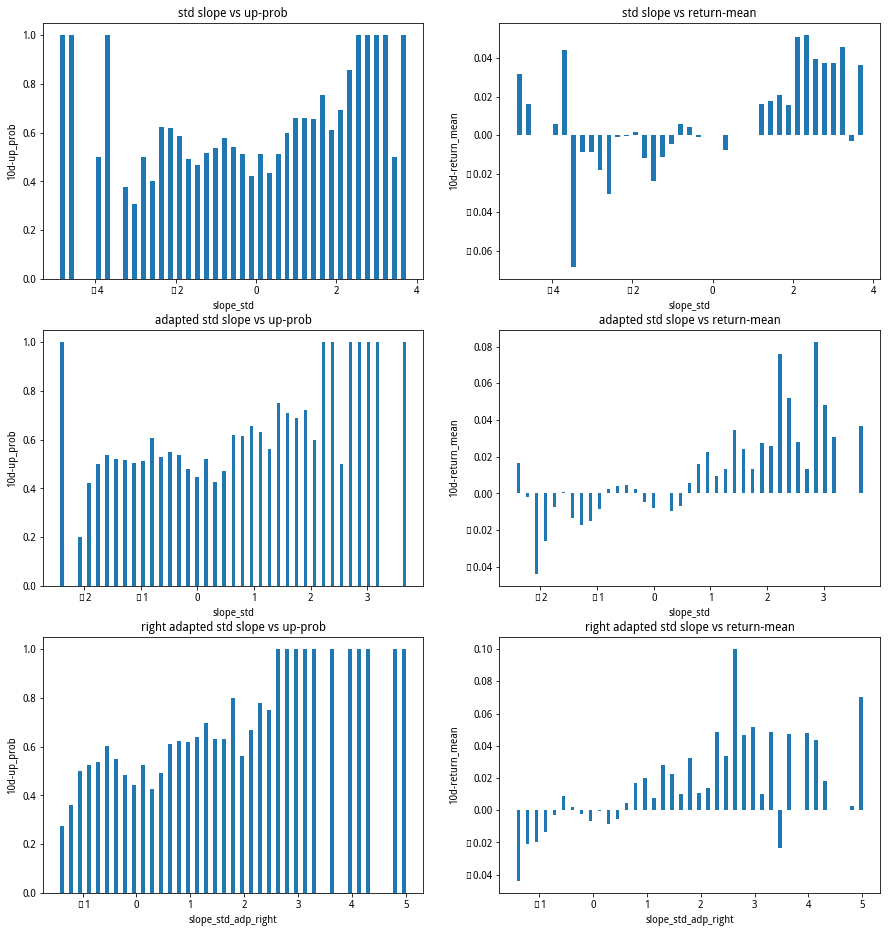

In [23]:

#######################标准分############################

#画直方图
return_store_std = return_store[~np.isnan(slope_std)].copy()
slope_std_new = slope_std[~np.isnan(slope_std)].copy()

x_space_std=linspace(min(slope_std_new),max(slope_std_new),40)
store_std = [[] for i in range(len(x_space_std)-1)]

for i in range(len(slope_std_new)):
    for j in range(len(x_space_std)-1):
        if slope_std_new[i]>=x_space_std[j] and slope_std_new[i]<(x_space_std[j+1]+0.0000000001):
            store_std[j].append(return_store_std[i])
            continue
prob_std = np.array([(np.array(uu)>0).mean() for uu in store_std])
mean_std = np.array([np.array(uu).mean() for uu in store_std])

#画图
plt.figure(figsize=(15,16))
plt.subplot(3,2,1)
plt.bar(x_space_std[:-1],prob_std,width=(x_space_std[1]-x_space_std[0]-0.1))
plt.xlabel("slope_std")
plt.ylabel("10d-up_prob")
plt.title("std slope vs up-prob")

plt.subplot(3,2,2)
plt.bar(x_space_std[:-1],mean_std,width=(x_space_std[1]-x_space_std[0]-0.1))
plt.xlabel("slope_std")
plt.ylabel("10d-return_mean")
plt.title("std slope vs return-mean")

#######################修正标准分############################

#画直方图
return_store_std_adp = return_store[~np.isnan(slope_std_adp)].copy()
slope_std_adp_new = slope_std_adp[~np.isnan(slope_std_adp)].copy()

x_space_std_adp=linspace(min(slope_std_adp_new),max(slope_std_adp_new),40)
store_std_adp = [[] for i in range(len(x_space_std_adp)-1)]

for i in range(len(slope_std_adp_new)):
    for j in range(len(x_space_std_adp)-1):
        if slope_std_adp_new[i]>=x_space_std_adp[j] and slope_std_adp_new[i]<(x_space_std_adp[j+1]+0.0000000001):
            store_std_adp[j].append(return_store_std_adp[i])
            continue
prob_std_adp = np.array([(np.array(uu)>0).mean() for uu in store_std_adp])
mean_std_adp = np.array([np.array(uu).mean() for uu in store_std_adp])

#画图
plt.subplot(3,2,3)
plt.bar(x_space_std_adp[:-1],prob_std_adp,width=(x_space_std_adp[1]-x_space_std_adp[0]-0.1))
plt.xlabel("slope_std")
plt.ylabel("10d-up_prob")
plt.title("adapted std slope vs up-prob")

plt.subplot(3,2,4)
plt.bar(x_space_std_adp[:-1],mean_std_adp,width=(x_space_std_adp[1]-x_space_std_adp[0]-0.1))
plt.xlabel("slope_std")
plt.ylabel("10d-return_mean")
plt.title("adapted std slope vs return-mean")

###########################右偏标准分##########################
#画直方图
return_store_std_adp_right = return_store[~np.isnan(slope_std_adp_right)].copy()
slope_std_adp_right_new = slope_std_adp_right[~np.isnan(slope_std_adp_right)].copy()

x_space_std_adp_right=linspace(min(slope_std_adp_right_new),max(slope_std_adp_right_new),40)
store_std_adp_right = [[] for i in range(len(x_space_std_adp_right)-1)]

for i in range(len(slope_std_adp_right_new)):
    for j in range(len(x_space_std_adp_right)-1):
        if slope_std_adp_right_new[i]>=x_space_std_adp_right[j] and slope_std_adp_right_new[i]<(x_space_std_adp_right[j+1]+0.0000000001):
            store_std_adp_right[j].append(return_store_std_adp_right[i])
            continue
prob_std_adp_right = np.array([(np.array(uu)>0).mean() for uu in store_std_adp_right])
mean_std_adp_right = np.array([np.array(uu).mean() for uu in store_std_adp_right])

#画图
plt.subplot(3,2,5)
plt.bar(x_space_std_adp_right[:-1],prob_std_adp_right,width=(x_space_std_adp_right[1]-x_space_std_adp_right[0]-0.1))
plt.xlabel("slope_std_adp_right")
plt.ylabel("10d-up_prob")
plt.title("right adapted std slope vs up-prob")

plt.subplot(3,2,6)
plt.bar(x_space_std_adp_right[:-1],mean_std_adp_right,width=(x_space_std_adp_right[1]-x_space_std_adp_right[0]-0.1))
plt.xlabel("slope_std_adp_right")
plt.ylabel("10d-return_mean")
plt.title("right adapted std slope vs return-mean")


In [24]:
#分别计算x-space对于return up-prob 和return mean 的相关系数
corr_prob_std = np.corrcoef(x_space_std[:-1][~np.isnan(prob_std)],prob_std[~np.isnan(prob_std)])[0][1]
corr_mean_std = np.corrcoef(x_space_std[:-1][~np.isnan(mean_std)],mean_std[~np.isnan(mean_std)])[0][1]

corr_prob_std_adp = np.corrcoef(x_space_std_adp[:-1][~np.isnan(prob_std_adp)],prob_std_adp[~np.isnan(prob_std_adp)])[0][1]
corr_mean_std_adp = np.corrcoef(x_space_std_adp[:-1][~np.isnan(mean_std_adp)],mean_std_adp[~np.isnan(mean_std_adp)])[0][1]

corr_prob_std_adp_right = np.corrcoef(x_space_std_adp_right[:-1][~np.isnan(prob_std_adp_right)],prob_std_adp_right[~np.isnan(prob_std_adp_right)])[0][1]
corr_mean_std_adp_right = np.corrcoef(x_space_std_adp_right[:-1][~np.isnan(mean_std_adp_right)],mean_std_adp_right[~np.isnan(mean_std_adp_right)])[0][1]

print("标准化斜率与未来十日上涨概率相关系数: %.3f"%corr_prob_std)
print("调整标准化斜率与未来十日上涨概率相关系数: %.3f"%corr_prob_std_adp)
print("右偏调整标准化斜率与未来十日上涨概率相关系数: %.3f"%corr_prob_std_adp_right)
print(32*'-')
print("标准化斜率与未来十日平均涨幅相关系数: %.3f"%corr_mean_std)
print("调整标准化斜率与未来十日平均涨幅相关系数: %.3f"%corr_mean_std_adp)
print("右偏调整标准化斜率与未来十日平均涨幅相关系数: %.3f"%corr_mean_std_adp_right)

标准化斜率与未来十日上涨概率相关系数: 0.361
调整标准化斜率与未来十日上涨概率相关系数: 0.693
右偏调整标准化斜率与未来十日上涨概率相关系数: 0.718
--------------------------------
标准化斜率与未来十日平均涨幅相关系数: 0.524
调整标准化斜率与未来十日平均涨幅相关系数: 0.774
右偏调整标准化斜率与未来十日平均涨幅相关系数: 0.659


### 可以发现右偏调整后上涨概率相关系数变高，但是与涨幅相关系数降低（与研报不一致，可能是时间区间导致的差别）

# *比较标准分，调整标准分，右偏调整标准分策略

In [25]:
#定义交易函数
def trade_adp(signal_array,buy_index,sell_index):
    #数据初始化
    data_test = data_panel.copy()
    data_test = data_test.dropna()

    OPEN = data_test.open.values
    CLOSE = data_test.close.values
    Indexs = data_test.index
    #Slope = data_test.slope
    #Slope_std = data_test.slope_std

    #策略初始化
    buyfee = 0.0013
    sellfee = 0.0013

    pnl = np.full(len(Indexs), np.nan)
    position = 0

    for idx,time_stamp in enumerate(Indexs):
        if idx<=1:
            pnl[idx]=1
            continue

        ##定义买入条件
        if signal_array[idx-1]>buy_index:
            if position==0:
                position = pnl[idx-1]/OPEN[idx]/(1+buyfee)
                pnl[idx] = position * CLOSE[idx]
            else:
                pnl[idx] = position * CLOSE[idx]
        ##定义卖出条件
        elif signal_array[idx-1]<sell_index:
            if position>0:
                pnl[idx] = position* OPEN[idx]*(1-sellfee)
                position = 0
            else:
                pnl[idx]=pnl[idx-1]
        else:
            if position>0:
                pnl[idx] = position* CLOSE[idx]
            else:
                pnl[idx]=pnl[idx-1]
    
    #防止时间戳错乱，转换成pd.Series格式
    pnl = pd.Series(pnl,index =Indexs)
    
    return pnl

In [26]:
pnl_std = trade_adp(signal_array = slope_std,buy_index=0.7,sell_index=-0.7)
pnl_std_adp = trade_adp(signal_array = slope_std_adp,buy_index=0.7,sell_index=-0.7)

In [27]:
#对计算过程封装
def get_slope(N,M):
    #N = 18
    data_test =data_panel.copy()
    data_test = data_test.dropna()

    Indexs = data_test.index
    High = data_test.high.values
    Low = data_test.low.values
    CLOSE = data_test.close.values


    slope = np.full(len(Indexs), np.nan)
    r_2 = np.full(len(Indexs), np.nan)

    slope_std = np.full(len(slope), np.nan)
    slope_std_adp = np.full(len(slope), np.nan)
    slope_std_adp_right = np.full(len(slope), np.nan)
    return_store = np.full(len(slope), np.nan)

    #M = 600

    for i in range(len(Indexs)):
        if i<N-1:
            continue
        slope_t,_,r_value_t,_,_ = stats.linregress(x=Low[(i+1-N):(i+1)],y=High[(i+1-N):(i+1)])    
        slope[i] = slope_t
        r_2[i] = r_value_t**2
        #标准化斜率
        slope_std[i] = (slope[i] - np.mean(slope[(i+1-M):(i+1)]))/np.std(slope[(i+1-M):(i+1)])

        if i<(len(Indexs)-10): 
            return_store [i] = CLOSE[i+10] / CLOSE[i]-1
            if i>=M: 
                #修正标准化斜率
                slope_std_adp[i] = r_2[i] * (slope[i] - np.mean(slope[(i+1-M):(i+1)]))/np.std(slope[(i+1-M):(i+1)])
                #右偏修正标准化斜率
                slope_std_adp_right[i] = slope_std_adp[i]*slope[i] 
    return slope_std,slope_std_adp,slope_std_adp_right

In [28]:
#由于右偏标准分N,M参数改变，需要重新计算
_,_,slope_std_right = get_slope(N=16,M=300)
pnl_std_adp_right = trade_adp(signal_array = slope_std_right,buy_index=0.7,sell_index=-0.7)

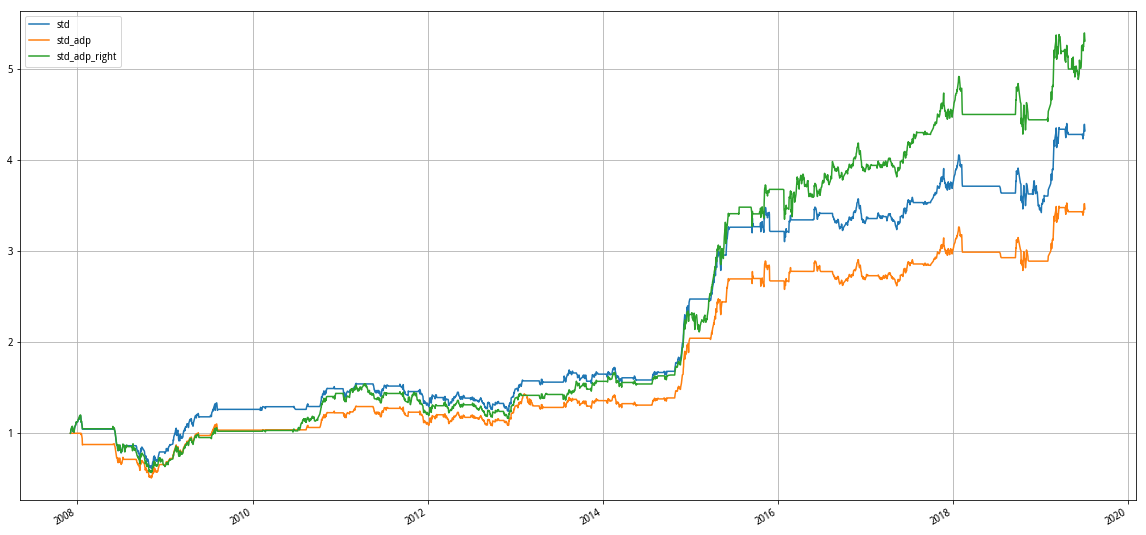

In [29]:
plt.figure(figsize=(20,10))

#计算开始画图起点
for i in range(len(pnl_std)):
    if pnl_std[i]==1 and pnl_std[i+1]!=1:
        begin_idx = i
        break
#画图
(pnl_std[begin_idx:]/pnl_std[begin_idx]).plot(label='std')
(pnl_std_adp[begin_idx:]/pnl_std_adp[begin_idx]).plot(label = 'std_adp')
(pnl_std_adp_right[begin_idx:]/pnl_std_adp_right[begin_idx]).plot(label = 'std_adp_right')

plt.legend()
plt.grid()

# *结合MA的优化策略

In [30]:
#定义交易函数--结合MA

def trade_adp_MA(signal_array,buy_index,sell_index):
    #数据初始化
    data_test = data_panel.copy()
    data_test = data_test.dropna()

    OPEN = data_test.open.values
    CLOSE = data_test.close.values
    Indexs = data_test.index
    MA_20 = data_test['close'].rolling(20).mean().values
    
    #策略初始化
    buyfee = 0.0013
    sellfee = 0.0013

    pnl = np.full(len(Indexs), np.nan)
    position = 0

    for idx,time_stamp in enumerate(Indexs):
        if idx<=1:
            pnl[idx]=1
            continue

        ##定义买入条件
        if signal_array[idx-1]>buy_index and MA_20[idx-1]>MA_20[idx-3]:
            if position==0:
                position = pnl[idx-1]/OPEN[idx]/(1+buyfee)
                pnl[idx] = position * CLOSE[idx]
            else:
                pnl[idx] = position * CLOSE[idx]
        ##定义卖出条件
        elif signal_array[idx-1]<sell_index:
            if position>0:
                pnl[idx] = position* OPEN[idx]*(1-sellfee)
                position = 0
            else:
                pnl[idx]=pnl[idx-1]
        else:
            if position>0:
                pnl[idx] = position* CLOSE[idx]
            else:
                pnl[idx]=pnl[idx-1]
    
    #防止时间戳错乱，转换成pd.Series格式
    pnl = pd.Series(pnl,index =Indexs)
    
    return pnl

In [31]:
pnl_std = trade_adp_MA(signal_array = slope_std,buy_index=0.7,sell_index=-0.7)
pnl_std_adp = trade_adp_MA(signal_array = slope_std_adp,buy_index=0.7,sell_index=-0.7)
pnl_std_adp_right = trade_adp_MA(signal_array = slope_std_right,buy_index=0.7,sell_index=-0.7)

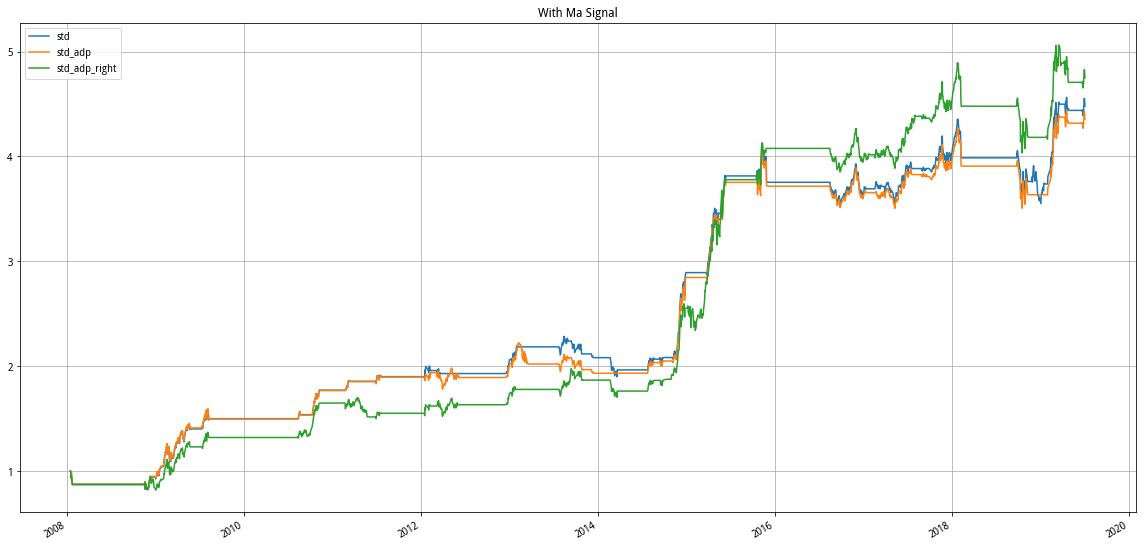

In [32]:
plt.figure(figsize=(20,10))

#计算开始画图起点
for i in range(len(pnl_std)):
    if pnl_std[i]==1 and pnl_std[i+1]!=1:
        begin_idx = i
        break
#画图
(pnl_std[begin_idx:]/pnl_std[begin_idx]).plot(label='std')
(pnl_std_adp[begin_idx:]/pnl_std_adp[begin_idx]).plot(label = 'std_adp')
(pnl_std_adp_right[begin_idx:]/pnl_std_adp_right[begin_idx]).plot(label = 'std_adp_right')

plt.title('With Ma Signal')
plt.legend()
plt.grid()

### 加入MA限制开仓后，用标准分斜率和修正无偏标准分斜率显著提高，而右偏修正标准分策略最终净值有所下滑

# *结合成交量的优化策略

In [33]:
#定义交易函数--结合Volume

def trade_adp_Volume(signal_array,buy_index,sell_index):
    #数据初始化
    data_test = data_panel.copy()
    data_test = data_test.dropna()

    OPEN = data_test.open.values
    CLOSE = data_test.close.values
    Volume =  data_test.volume.values
    
    Indexs = data_test.index
    MA_20 = data_test['close'].rolling(20).mean().values
    
    #策略初始化
    buyfee = 0.0013
    sellfee = 0.0013

    pnl = np.full(len(Indexs), np.nan)
    position = 0

    for idx,time_stamp in enumerate(Indexs):
        if idx<=9:
            pnl[idx]=1
            continue

        ##定义买入条件
        if signal_array[idx-1]>buy_index and np.corrcoef(slope_std[(idx-10):idx],Volume[(idx-10):idx])[0][1]>0:
            if position==0:
                position = pnl[idx-1]/OPEN[idx]/(1+buyfee)
                pnl[idx] = position * CLOSE[idx]
            else:
                pnl[idx] = position * CLOSE[idx]
        ##定义卖出条件
        elif signal_array[idx-1]<sell_index:
            if position>0:
                pnl[idx] = position* OPEN[idx]*(1-sellfee)
                position = 0
            else:
                pnl[idx]=pnl[idx-1]
        else:
            if position>0:
                pnl[idx] = position* CLOSE[idx]
            else:
                pnl[idx]=pnl[idx-1]
    
    #防止时间戳错乱，转换成pd.Series格式
    pnl = pd.Series(pnl,index =Indexs)
    
    return pnl

In [34]:
pnl_std = trade_adp_Volume(signal_array = slope_std,buy_index=0.7,sell_index=-0.7)
pnl_std_adp = trade_adp_Volume(signal_array = slope_std_adp,buy_index=0.7,sell_index=-0.7)
pnl_std_adp_right = trade_adp_Volume(signal_array = slope_std_right,buy_index=0.7,sell_index=-0.7)

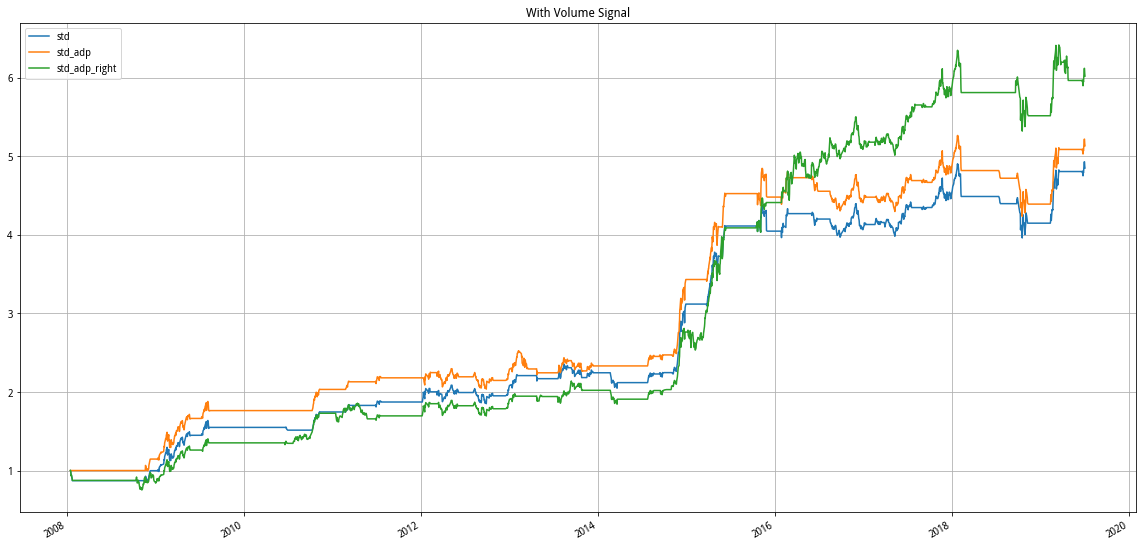

In [35]:
plt.figure(figsize=(20,10))

#计算开始画图起点
for i in range(len(pnl_std)):
    if pnl_std[i]==1 and pnl_std[i+1]!=1:
        begin_idx = i
        break
#画图
(pnl_std[begin_idx:]/pnl_std[begin_idx]).plot(label='std')
(pnl_std_adp[begin_idx:]/pnl_std_adp[begin_idx]).plot(label = 'std_adp')
(pnl_std_adp_right[begin_idx:]/pnl_std_adp_right[begin_idx]).plot(label = 'std_adp_right')

plt.title('With Volume Signal')
plt.legend()
plt.grid()

### 可以看到均有提高，且右偏调整的标准斜率策略有显著提升

In [ ]:
## M值敏感性测试
sharp_store_std=[]
sharp_store_std_adp=[]
sharp_store_std_adp_right=[]
M_list = np.arange(100,900,50)

for M in M_list:
    slope_std,slope_std_adp,slope_std_right = get_slope(N=18,M=M)
    pnl_std = trade_adp(signal_array = slope_std,buy_index=0.7,sell_index=-0.7)
    pnl_std_adp = trade_adp(signal_array = slope_std_adp,buy_index=0.7,sell_index=-0.7)
    pnl_std_adp_right = trade_adp(signal_array = slope_std_right,buy_index=0.7,sell_index=-0.7)
    sharp_store_std.append(sharp_ratio(pnl_std[900:]))
    sharp_store_std_adp.append(sharp_ratio(pnl_std_adp[900:]))
    sharp_store_std_adp_right.append(sharp_ratio(pnl_std_adp_right[900:]))

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(M_list,sharp_store_std,label="标准分夏普")
plt.plot(M_list,sharp_store_std_adp,label="调整标准分夏普")
plt.plot(M_list,sharp_store_std_adp_right,label="右偏调整标准分夏普")
plt.ylabel("sharp_ratio")
plt.xlabel("M_value")
plt.legend()
plt.grid()

### 可以看出对于调整和标准的斜率，M达到600后不再创新高，而右偏调整的标准分在300和800达到高点